# Predicting no-show patients at a Dental Practice

## Introduction

### Goal
To document steps used to create a machine learning algorithm that predicts patient attendance.

### Steps

1) Feature Engineering

2) Building ML model

3) Hyperparameter Tuning

4) Visualizing model output





## 1) Automatic Feature Creation using featuretools

In [1]:
import featuretools as ft
import featuretools.variable_types as vtypes
import pandas as pd
import os
import multiprocess as mp
import pickle

# Load the model from disk
weather = pickle.load(open('data/weather2018.pkl', 'rb'))
weather = pd.DataFrame(weather)

#read current working directory
##assume running notebook from No_show_patience directory
cwd = os.getcwd()


#import and load data
full_dataset = pd.read_pickle(cwd + "/data/preFT2018.pkl")
#use below code at experimentation stage to build new features on a small dataset.
#full_dataset = full_dataset.iloc[:5,:]

full_dataset.AppointmentDate = (pd.to_datetime(full_dataset.AppointmentDate) + 
                                (pd.Timedelta(days = 1) - pd.Timedelta(seconds = 1)) * (full_dataset.noshow))





In [2]:
keep = ['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId']
full_dataset=full_dataset[keep]
full_dataset.iloc[0:9,:].to_csv(cwd + "/data/head.csv")


In [3]:

x = full_dataset['AppointmentDate'].dt.round('60min')
full_dataset['datetime'] = pd.to_datetime(x)
weather['datetime'] = pd.to_datetime(weather['time'],unit='s').dt.round('60min')
full_dataset = full_dataset.merge(weather,on='datetime', how="left")

In [4]:
full_dataset.iloc[:2,20:45]

Age_npf         Patient  AppointmentId            datetime        time  \
0      NaN     David Morin              0 2018-09-26 14:00:00  1537970400   
1     30.0  Virginia North              1 2018-06-21 09:00:00  1529571600   

         summary                 icon precipIntensity precipProbability  \
0  Mostly Cloudy    partly-cloudy-day               0                 0   
1  Partly Cloudy  partly-cloudy-night               0                 0   

  temperature  ... pressure windSpeed windGust windBearing cloudCover uvIndex  \
0       74.89  ...  1016.71      5.94     5.94         182       0.55       3   
1       69.44  ...  1007.07      1.15     1.15         207       0.43       0   

  visibility precipType precipAccumulation  ozone  
0      7.197        NaN                NaN  273.1  
1      5.282        NaN                NaN    NaN  

[2 rows x 23 columns]

In [941]:
variable_types = {'PatientId':vtypes.Numeric, 'newbie':vtypes.Boolean,'insuranceDummy':vtypes.Boolean, 
                  'guarantorIsPatient':vtypes.Boolean, 'loyalty':vtypes.Numeric, 'noshow':vtypes.Boolean, 
                  'PatientEmail':vtypes.EmailAddress,'GuarantorEmail':vtypes.EmailAddress,
                  'PatientPhone1':vtypes.PhoneNumber, 'patientEmailDomain':vtypes.Categorical,
                  'guarantorEmailDomain':vtypes.Categorical, 'patientPhone1AreaCode':vtypes.Categorical, 
                  'insurance':vtypes.Categorical, 'provider':vtypes.Categorical, 
                  'source':vtypes.Categorical, 'procedure':vtypes.Categorical,
                  'weekday':vtypes.Categorical, 'apptType':vtypes.Categorical,
                  "newpatientfile":vtypes.Ordinal, "Age_npf":vtypes.Numeric, "Patient":vtypes.Text,
                  'summary':vtypes.Text, 'icon':vtypes.Text, 'precipIntensity':vtypes.Numeric, 
                  'temperature':vtypes.Numeric,'apparentTemperature':vtypes.Numeric, 'dewPoint':vtypes.Numeric,
                  'humidity':vtypes.Numeric, 'pressure':vtypes.Numeric, 'windSpeed':vtypes.Numeric,
                  'windGust':vtypes.Numeric, 'windBearing':vtypes.Numeric, 'cloudCover':vtypes.Numeric,
                 }
variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId','summary', 'icon',
                  'precipIntensity', 'temperature',
                  'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
                  'windGust', 'windBearing', 'cloudCover'])

# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=full_dataset[variable_list],
                              index='AppointmentId',
                              time_index='AppointmentDate',
                              variable_types=variable_types)
es['appointments']

# Make patients, weekdays, emails and insurances entities

es.normalize_entity(base_entity_id='appointments', new_entity_id='patients', index='PatientId', 
                    additional_variables = ['Patient', 'PatientEmail', 'GuarantorEmail', 'PatientPhone1',
                                            'newpatientfile', 'Age_npf'], make_time_index=True)
# 'PatientEmail', 'GuarantorEmail', 'PatientPhone1'
es.normalize_entity('appointments', 'patientemails', 'patientEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'guarantoremails', 'guarantorEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'patientPhones', 'patientPhone1AreaCode',make_time_index=True)
es.normalize_entity('appointments', 'insurances', 'insurance',make_time_index=True)
es.normalize_entity('appointments', 'providers', 'provider', make_time_index=True)
es.normalize_entity('appointments', 'sources', 'source', make_time_index=True)
es.normalize_entity('appointments', 'procedures', 'procedure', make_time_index=True)
es.normalize_entity('appointments', 'weekdays', 'weekday', make_time_index=True)
es.normalize_entity('appointments', 'apptTypes', 'apptType',make_time_index=True)


Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 29]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [717]:
print(es)

Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 29]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [968]:
cutoff_times =  es['appointments'].df[['AppointmentId','AppointmentDate']]
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']

X_ft, features = ft.dfs(entityset=es,
                        target_entity='appointments',
                        agg_primitives=['count', 'percent_true', 'num_true', 'trend', 'skew', 'all', 'std',
                                       'max', 'mean', 'min', 'median', 'num_unique'],
                        max_depth=2,
                        trans_primitives=['day', 'month', 'year', 'num_words', 'num_characters'],
                        cutoff_time=cutoff_times,
                        verbose=True,
                        approximate = '3h',
                        #approximate = "1 day",
                        chunk_size=50,
                        n_jobs=mp.cpu_count())

Built 1056 features


Elapsed: 00:00 | Progress:   0%|          

Elapsed: 00:00 | Progress:   0%|          | Remaining: ?

                                                              
                                                           

                                                  EntitySet scattered to 4 workers in 9 seconds
Elapsed: 6:01:57 | Progress:  79%|███████▉  | Remaining: 30:50
Elapsed: 4:22:34 | Progress:  49%|████▉     | Remaining: 54:59

Elapsed: 00:00 | Progress:   0%|          | Remaining: ?

Elapsed: 00:04 | Progress:   0%|          | Remaining: 2:27:43

Elapsed: 00:09 | Progress:   0%|          | Remaining: 2:22:51

Elapsed: 00:13 | Progress:   0%|          | Remaining: 2:19:39

Elapsed: 00:13 | Progress:   0%|          | Remaining: 2:12:35

Elapsed: 00:13 | Progress:   1%|          | Remaining: 2:06:16

Elapsed: 00:21 | Progress:   1%|          | Remaining: 2:03:44

Elapsed: 00:22 | Progress:   1%|          | Remaining: 2:02:24

Elapsed: 00:25 | Progre

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/distr



Elapsed: 52:47 | Progress: 100%|██████████| Remaining: 00:00

Elapsed: 52:47 | Progress: 100%|██████████| Remaining: 00:00


In [969]:
X_ft.head()

PatientId  newbie  insuranceDummy  guarantorIsPatient  loyalty  \
AppointmentId                                                                   
319                 9608       0               0                True       19   
1526                9393       0               0                True       10   
4249                9200       0               1                True       24   
42                  8562       0               0                True       19   
1942                9961       0               0                True       19   

               noshow      patientEmailDomain      guarantorEmailDomain  \
AppointmentId                                                             
319                 0  PatientEmail_gmail.com  GuarantorEmail_gmail.com   
1526                0     PatientEmail_others     GuarantorEmail_others   
4249                0  PatientEmail_gmail.com  GuarantorEmail_gmail.com   
42                  0     PatientEmail_others     GuarantorEmail_others   
1942                0  PatientEmail_GMAIL.COM  GuarantorEmail_GMAIL.COM   

              patientPhone1AreaCode  \
AppointmentId                         
319               PatientPhone1_434   
1526              PatientPhone1_434   
4249           PatientPhone1_others   
42                PatientPhone1_434   
1942              PatientPhone1_540   

                                                insurance  ...  \
AppointmentId                                              ...   
319                                      Insurance_others  ...   
1526                                     Insurance_others  ...   
4249           Insurance_UNITED CONCORDIA                  ...   
42                                       Insurance_others  ...   
1942                                     Insurance_others  ...   

              apptTypes.NUM_UNIQUE(appointments.guarantorEmailDomain)  \
AppointmentId                                                           
319                                                          NaN        
1526                                                         NaN        
4249                                                         NaN        
42                                                           2.0        
1942                                                         2.0        

              apptTypes.NUM_UNIQUE(appointments.patientPhone1AreaCode)  \
AppointmentId                                                            
319                                                          NaN         
1526                                                         NaN         
4249                                                         NaN         
42                                                           2.0         
1942                                                         2.0         

              apptTypes.NUM_UNIQUE(appointments.insurance)  \
AppointmentId                                                
319                                                    NaN   
1526                                                   NaN   
4249                                                   NaN   
42                                                     2.0   
1942                                                   1.0   

              apptTypes.NUM_UNIQUE(appointments.provider)  \
AppointmentId                                               
319                                                   NaN   
1526                                                  NaN   
4249                                                  NaN   
42                                                    1.0   
1942                                                  2.0   

              apptTypes.NUM_UNIQUE(appointments.source)  \
AppointmentId                                             
319                                                 NaN   
1526                                                NaN   
4249                                                Na

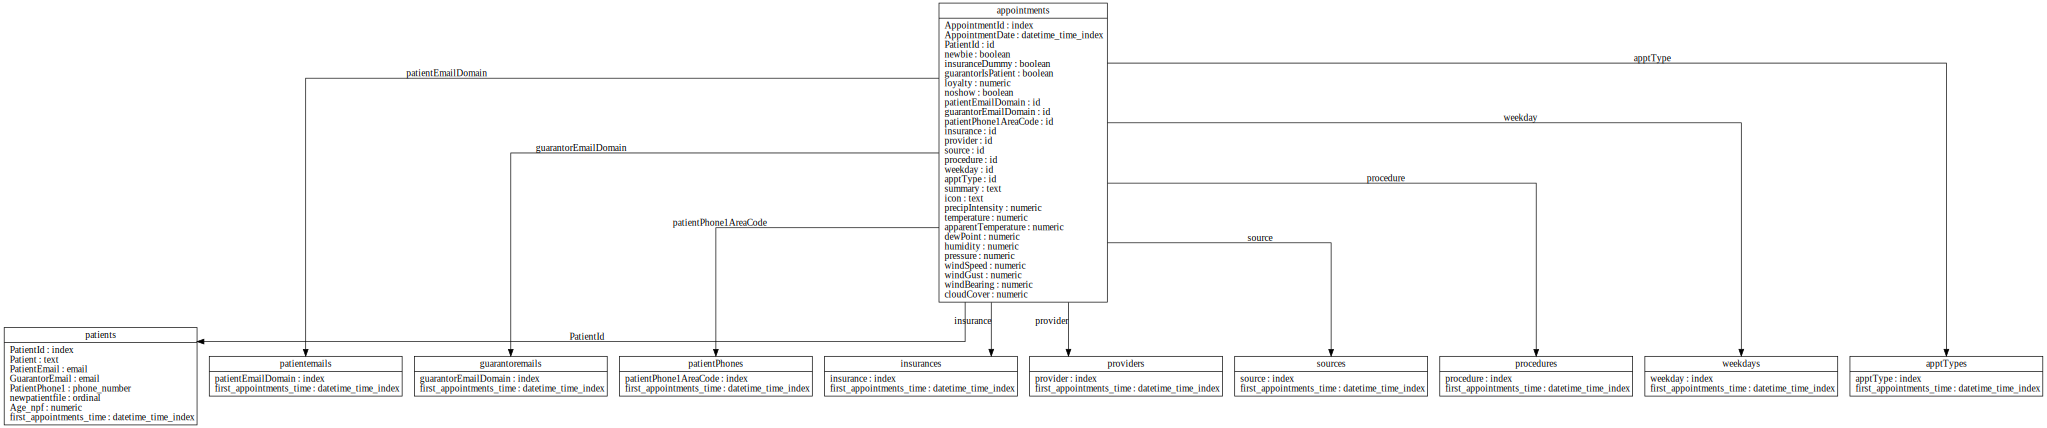

In [970]:
es.plot()

## 2) Building ML models

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
import pandas as pd
import numpy as np
import multiprocess as mp
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import os

cwd = os.getcwd()

In [12]:
#pickle that data set. only do this when you want to replace
#X_ft.drop(cat_cols,axis=1).to_pickle(cwd + "/data/postFT_insight_weather.pkl")
full_dataset = pd.read_pickle(cwd + "/data/postFT_insight.pkl")

In [13]:
##skip this step if loading in pickle
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
           'patientPhone1AreaCode','weekday', 'apptType','source']


##import and load data
full_dataset = pd.concat([X_ft],axis=1).drop(cat_cols,axis=1)

NameError: name 'X_ft' is not defined

In [14]:
##if loading pickle, drop in here
X = full_dataset.drop(['noshow'],axis=1)
y = full_dataset[['noshow']]



In [16]:
X.head()

PatientId  newbie  insuranceDummy  guarantorIsPatient  loyalty  \
AppointmentId                                                                   
319                 9608       0               0                True       19   
1526                9393       0               0                True       10   
4249                9200       0               1                True       24   
42                  8562       0               0                True       19   
1942                9961       0               0                True       19   

               DAY(AppointmentDate)  MONTH(AppointmentDate)  \
AppointmentId                                                 
319                               2                       1   
1526                              2                       1   
4249                              2                       1   
42                                2                       1   
1942                              2                       1   

               YEAR(AppointmentDate)  patients.newpatientfile  \
AppointmentId                                                   
319                             2018                   201606   
1526                            2018                   201703   
4249                            2018                   201611   
42                              2018                   201606   
1942                            2018                   201606   

               patients.Age_npf  ...  \
AppointmentId                    ...   
319                         NaN  ...   
1526                       54.0  ...   
4249                       35.0  ...   
42                          NaN  ...   
1942                        NaN  ...   

               sources.NUM_UNIQUE(appointments.YEAR(AppointmentDate))  \
AppointmentId                                                           
319                                                          NaN        
1526                                                         NaN        
4249                                                         NaN        
42                                                           1.0        
1942                                                         1.0        

               procedures.NUM_UNIQUE(appointments.DAY(AppointmentDate))  \
AppointmentId                                                             
319                                                          NaN          
1526                                                         NaN          
4249                                                         NaN          
42                                                           1.0          
1942                                                         1.0          

               procedures.NUM_UNIQUE(appointments.MONTH(AppointmentDate))  \
AppointmentId                                                               
319                                                          NaN            
1526                                                         NaN            
4249                                                         NaN            
42                                                           1.0            
1942                                                         1.0            

               procedures.NUM_UNIQUE(appointments.YEAR(AppointmentDate))  \
AppointmentId                                                              
319                                                          NaN           
1526                                                         NaN           
4249                                                         NaN           
42                                                           1.0           
1942                                                         1.0           

               weekdays.NUM_UNIQUE(appointments.DAY(AppointmentDate))  \
AppointmentId                                                           
319        

In [17]:
#split 2018 data into training and test sets, setting a seed for replication purposes
cutoff_month = 8
X_train, X_test, y_train, y_test = (X[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    X[X['MONTH(AppointmentDate)']>cutoff_month],
                                    y[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    y[X['MONTH(AppointmentDate)']>cutoff_month])


# Explicitly impute values for missing fields for RF and Log
X_train, X_test = X_train.fillna(X_train.mean()), X_test.fillna(X_test.mean())
X_train, X_test = X_train.fillna(0), X_test.fillna(0)



In [18]:
#logistic regression model
model_log = LogisticRegression(solver="liblinear", C=0.5, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_log = model_log.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
from sklearn.ensemble import RandomForestClassifier
#random forest model
model_rf = RandomForestClassifier(n_estimators=1000, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_rf = model_rf.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
##XGBoost
from xgboost import XGBClassifier, plot_importance

#XGB - automatically deals with missing values during training
model_xgb = (XGBClassifier(n_estimators=50, max_depth = 3, eta = 0.1, subsample = 0.6, 
                           n_thread = 4, random_state=1, alpha = 0,
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb = model_xgb.predict_proba(X_test)

In [21]:
print("The AUC score of the Log Reg model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_log)[1]),2)))
print("The AUC score of the RF model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_rf)[1]),2)))
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))


The AUC score of the Log Reg model is: 0.59
The AUC score of the RF model is: 0.62
The AUC score of the XGB model is: 0.64


### 3) Hyperparameter Tuning

In [956]:
score = 'roc_auc' #originally also roc_auc

#### max depth

In [427]:
#max depth
param_test2 = {'max_depth':range(5,45,10)}

gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test2, scoring=score, iid=False)

gsearch2.fit(X_train,y_train.values.ravel())
gsearch2.best_params_, gsearch2.best_score_



({'max_depth': 5}, 0.4294061753523343)

In [550]:
#max depth fine tune
param_test3 = {'max_depth':[1,2,3,4,5]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test3, scoring=score, iid=False)

gsearch3.fit(X_train,y_train.values.ravel())
gsearch3.best_params_, gsearch3.best_score_



({'max_depth': 1}, 0.5252645728348619)

#### max estimators

In [433]:
#n_estimators
param_test4 = {'n_estimators':range(200,1400,200)}

gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 15, eta = 0.15, subsample = 0.05,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test4, scoring=score, iid=False)

gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_


({'n_estimators': 1400}, 0.39451219942824595)

In [ ]:
#n_estimators
# param_test4 = {'n_estimators':[6,12,25, 50, 100,200]}

# gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
#                                                   n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
#                         cv=5, param_grid = param_test4, scoring=score, iid=False)

# gsearch4.fit(X_train,y_train.values.ravel())
# gsearch4.best_params_, gsearch4.best_score_

#### eta

In [429]:
#eta
param_test5 = {'eta':[i/20.0 for i in range(1,8)]}

gsearch5 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test5, scoring=score, iid=False)

gsearch5.fit(X_train,y_train.values.ravel())
gsearch5.best_params_, gsearch5.best_score_


({'eta': 0.05}, 0.4695702357086097)

#### subsample

In [430]:
#subsample
param_test6 = {'subsample':[i/10.0 for i in range(1,9,2)]}

gsearch6 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test6, scoring=score, iid=False)

gsearch6.fit(X_train,y_train.values.ravel())
gsearch6.best_params_, gsearch6.best_score_


({'subsample': 0.7}, 0.48850880411072073)

#### alpha 

In [431]:
#alpha rate
param_test1 = {'alpha':[0, 1e-2, 0.1, 1, 10, 100, 1000]}

gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=800,max_depth = 3, eta = 0.05, subsample = 0.5,
                                                  n_thread = 4, random_state=1, alpha = 0.5,tree_method = 'hist'),
                        cv=5, param_grid = param_test1, scoring=score, iid=False)

gsearch1.fit(X_train,y_train.values.ravel())
gsearch1.best_params_, gsearch1.best_score_
##alpha of 0 is best

({'alpha': 0}, 0.452583278480195)

#### gamma

In [438]:
import numpy as np
#gamma rate
param_test7 = {'gamma':[0.0, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_


({'gamma': 16.0}, 0.46834822660837644)

In [439]:
#gamma rate
param_test7 = {'gamma':[16.0, 32.0]}
gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=1400, max_depth = 3, eta = 0.05, subsample = 0.7, 
                           n_thread = 4, random_state=1, alpha = 0,gamma =25,
                           tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_

({'gamma': 16.0}, 0.46834822660837644)

#### all together

In [ ]:
param_test8 = {'gamma':[np.arange(0, 10, 0.5)],
               'max_depth':[range(5,30,5)],
               'n_estimators':[range(200,2000,200)],
               'eta':[i/20.0 for i in range(1,6)],
               'subsample':[i/10.0 for i in range(1,9,2)],
              }
eval_set = [X_test, y_test.values.ravel()]
gsearch8 = GridSearchCV(estimator = XGBClassifier(n_estimators=1400,max_depth = , eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist',eval_metric='auc', eval_set=eval_set,early_stopping_rounds=10),
                        cv=5, param_grid = param_test8, scoring='roc_auc', iid=False)


gsearch8.fit(X_train,y_train.values.ravel())
gsearch8.best_params_, gsearch8.best_score_
#parameters for roc_auc without weather
# ({'eta': 0.05,
#   'gamma': 0.0,
#   'max_depth': 1,
#   'n_estimators': 25,
#   'subsample': 0.5},
#  0.582821084090225)


In [31]:
##XGBoost with updated stuff
from xgboost import XGBClassifier, plot_importance

eval_set = [(X_train, y_train.values.ravel()), (X_test, y_test.values.ravel())]

#XGB - automatically deals with missing values during training
model_xgb_PT = XGBClassifier(n_estimators=1400, max_depth = 5, eta = 0.05, subsample = 0.7, 
                           n_thread = 4, random_state=1, alpha = 0,gamma =10,objective= 'binary:logistic',
                           tree_method = 'hist').fit(X_train, y_train.values.ravel(), 
                                                     eval_metric=["error", "logloss","auc"], eval_set=eval_set,early_stopping_rounds=10, verbose=False)
y_pred_model_xgb_PT = model_xgb_PT.predict_proba(X_test)
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1]),2)))


The AUC score of the XGB model is: 0.7


### 4) Visualizing Model 


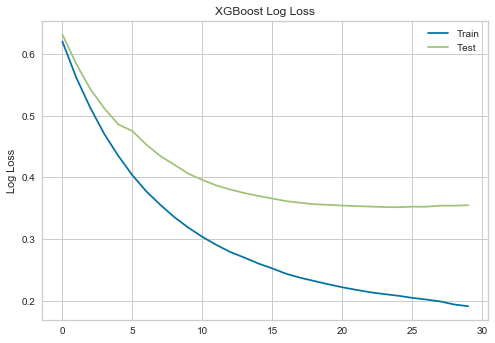

In [32]:
from matplotlib import pyplot

# retrieve performance metrics
results = model_xgb_PT.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


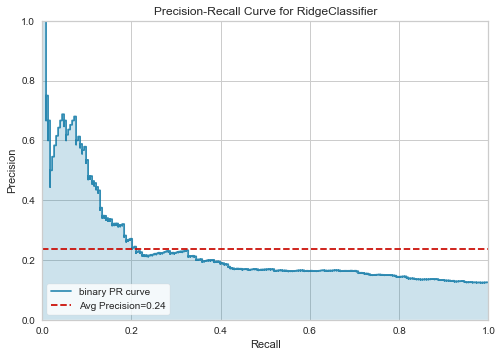

In [33]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_spam

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(RidgeClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

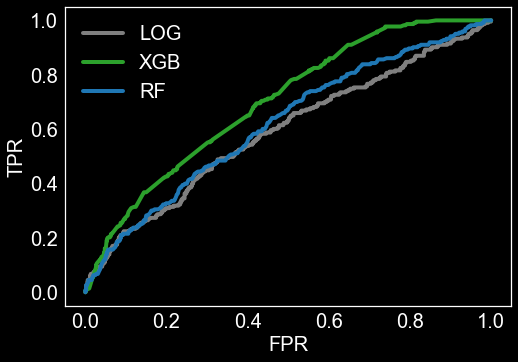

In [140]:
##comparing LOG, XGB, RF

import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

##tableau colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode


# ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
# ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)    

##calculate false positive and true positive rates
fpr, tpr,_=roc_curve(y_test,pd.DataFrame(y_pred_model_log)[1],drop_intermediate=False)
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_3, tpr_3,_=roc_curve(y_test,pd.DataFrame(y_pred_model_rf)[1],drop_intermediate=False)


# plot ROC and reference
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.plot(fpr, tpr, color=tableau20[14], lw=4, label='LOG')
plt.plot(fpr_2, tpr_2, color=tableau20[4], lw=4, label='XGB')
plt.plot(fpr_3, tpr_3, color=tableau20[0], lw=4, label='RF')

##Title and label
plt.xlabel('FPR', fontsize = 20)
plt.ylabel('TPR', fontsize =20)
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('data/MVP_ROCcurve.png', transparent=True)
plt.show()

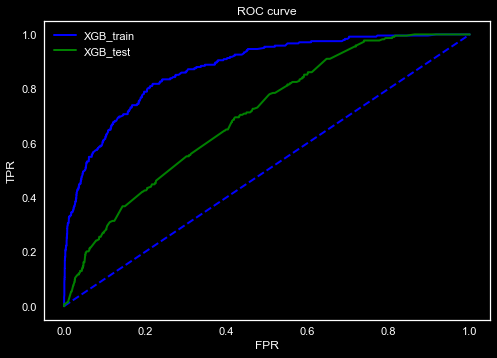

In [141]:
import matplotlib.pyplot as plt

y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)

##comparing ROC for XGB train and test
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_train, tpr_train,_=roc_curve(y_train,pd.DataFrame(y_pred_model_xgb_train)[1],drop_intermediate=False)


plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='XGB_train')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB_test')


##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')


plt.savefig(cwd + '/data/test_vs_train.png')
plt.show()

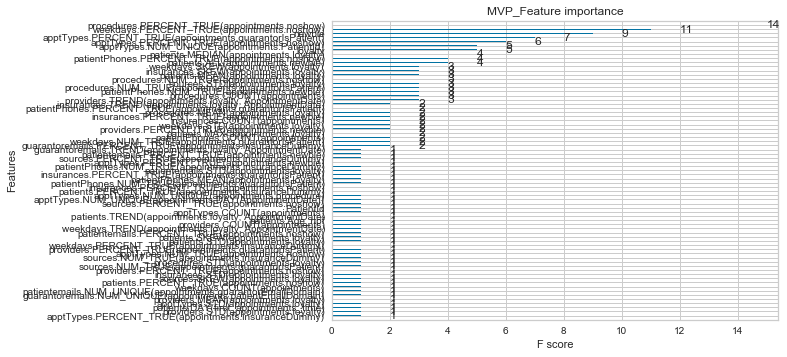

In [38]:

fig, ax = plt.subplots() #figsize=(10, 200)
plot_importance(model_xgb_PT, ax=ax)
plt.title('MVP_Feature importance')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_Feature_importance.png')
plt.show()

#### percentage vs no show

In [42]:
y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)
train_percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_train[:,1]})

In [43]:
##are all indexes the same
same_index = y_train.index == X_train.index
same_index.all()

True

In [44]:
#sanity check. where to call it no shows?
table = pd.concat([X_train['PatientId'].reset_index(drop=True), y_train.reset_index(drop=True), train_percent_noshow.reset_index(drop=True)], axis=1)
table

PatientId  noshow  percent_noshow
0          9608       0        0.108599
1          9393       0        0.108599
2          9200       0        0.108599
3          8562       0        0.071192
4          9961       0        0.071192
...         ...     ...             ...
3656       7685       0        0.112809
3657       4515       0        0.153788
3658       6830       0        0.158504
3659       1390       1        0.140617
3660      10284       1        0.164022

[3661 rows x 3 columns]

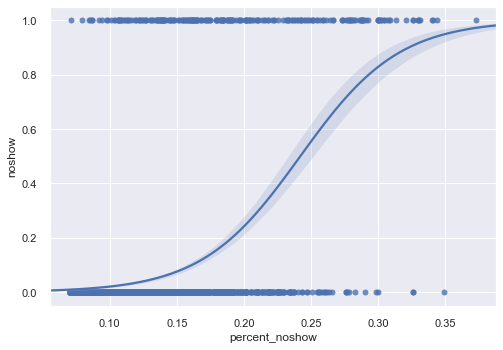

In [142]:
##training data
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=table)
fig = ax.get_figure()
fig.savefig("percent_noshow_logistic.png")

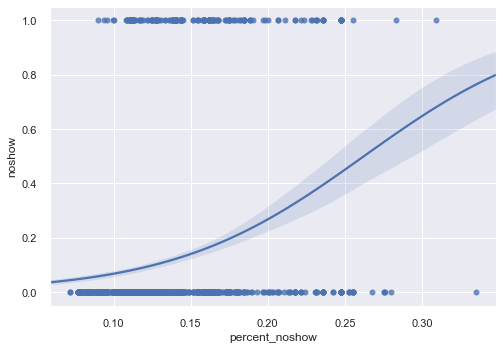

In [46]:
##test_data
percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_PT[:,1]})
test_table = pd.concat([X_test['PatientId'].reset_index(drop=True), y_test.reset_index(drop=True), percent_noshow.reset_index(drop=True)], axis=1)

test_logistic = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=test_table)
test_logistic = test_logistic.get_figure()
test_logistic.savefig("percent_noshow_logistic_test.png")

In [47]:
no_show_likely = test_table[test_table['percent_noshow']>0.18407562]
no_show_unlikely = test_table[test_table['percent_noshow']<0.18407562]
pd.crosstab(no_show_likely.noshow, no_show_likely.percent_noshow)

percent_noshow  0.184225  0.184542  0.184888  0.186521  0.188313  0.189103  \
noshow                                                                       
0                      1         3         2         2         0         1   
1                      0         6         0         0         3         0   

percent_noshow  0.190058  0.190762  0.192822  0.196731  ...  0.252545  \
noshow                                                  ...             
0                      1         0         1         0  ...         3   
1                      0         1         0         1  ...         0   

percent_noshow  0.254851  0.255566  0.267968  0.275178  0.276047  0.280163  \
noshow                                                                       
0                      1         5         1         2         1         1   
1                      0         1         0         0         0         0   

percent_noshow  0.283390  0.309095  0.334961  
noshow                                        
0                      0         0         1  
1                      1         1         0  

[2 rows x 49 columns]

In [48]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

gap = minmax(test_table.percent_noshow)
step_size = (gap[1]-gap[0])/100

cutoffs = np.arange(gap[0], gap[1], step_size)
cutoffs

array([0.07177044, 0.07440235, 0.07703425, 0.07966616, 0.08229806,
       0.08492997, 0.08756187, 0.09019378, 0.09282568, 0.09545759,
       0.09808949, 0.1007214 , 0.1033533 , 0.10598521, 0.10861711,
       0.11124902, 0.11388092, 0.11651283, 0.11914473, 0.12177664,
       0.12440854, 0.12704045, 0.12967235, 0.13230426, 0.13493616,
       0.13756807, 0.14019997, 0.14283188, 0.14546378, 0.14809569,
       0.15072759, 0.1533595 , 0.1559914 , 0.15862331, 0.16125521,
       0.16388712, 0.16651902, 0.16915093, 0.17178283, 0.17441474,
       0.17704664, 0.17967855, 0.18231045, 0.18494236, 0.18757426,
       0.19020617, 0.19283807, 0.19546998, 0.19810188, 0.20073379,
       0.20336569, 0.2059976 , 0.2086295 , 0.21126141, 0.21389331,
       0.21652522, 0.21915712, 0.22178903, 0.22442093, 0.22705284,
       0.22968474, 0.23231665, 0.23494855, 0.23758046, 0.24021236,
       0.24284426, 0.24547617, 0.24810807, 0.25073998, 0.25337188,
       0.25600379, 0.25863569, 0.2612676 , 0.2638995 , 0.26653

In [49]:
no_show_unlikely[no_show_unlikely.noshow ==0].shape[0] /no_show_unlikely.shape[0]


0.8925178147268409

In [50]:
no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]

0.3333333333333333

In [51]:
no_show_precision = []
for i in cutoffs:
    no_show_likely = test_table[test_table['percent_noshow']>i]
    no_show_unlikely = test_table[test_table['percent_noshow']<i]
    precision = no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]
    percentage = (i-gap[0])/(gap[1]-gap[0])*100
    proportion = no_show_likely.shape[0] / test_table.shape[0]
    total = no_show_likely.shape[0]
    data = [percentage, precision, proportion, total]
    no_show_precision.append(data)



    
    

In [52]:
test_table.shape[0]

1810

In [53]:
no_show_precision = pd.DataFrame(no_show_precision, columns = ['percentile', 'precision', 'proportion', 'total'])
no_show_precision[no_show_precision['percentile']>70]

percentile  precision  proportion  total
70        70.0   0.250000    0.004420      8
71        71.0   0.250000    0.004420      8
72        72.0   0.250000    0.004420      8
73        73.0   0.250000    0.004420      8
74        74.0   0.250000    0.004420      8
75        75.0   0.285714    0.003867      7
76        76.0   0.285714    0.003867      7
77        77.0   0.285714    0.003867      7
78        78.0   0.500000    0.002210      4
79        79.0   0.500000    0.002210      4
80        80.0   0.666667    0.001657      3
81        81.0   0.500000    0.001105      2
82        82.0   0.500000    0.001105      2
83        83.0   0.500000    0.001105      2
84        84.0   0.500000    0.001105      2
85        85.0   0.500000    0.001105      2
86        86.0   0.500000    0.001105      2
87        87.0   0.500000    0.001105      2
88        88.0   0.500000    0.001105      2
89        89.0   0.500000    0.001105      2
90        90.0   0.500000    0.001105      2
91        91.0   0.000000    0.000552      1
92        92.0   0.000000    0.000552      1
93        93.0   0.000000    0.000552      1
94        94.0   0.000000    0.000552      1
95        95.0   0.000000    0.000552      1
96        96.0   0.000000    0.000552      1
97        97.0   0.000000    0.000552      1
98        98.0   0.000000    0.000552      1
99        99.0   0.000000    0.000552      1

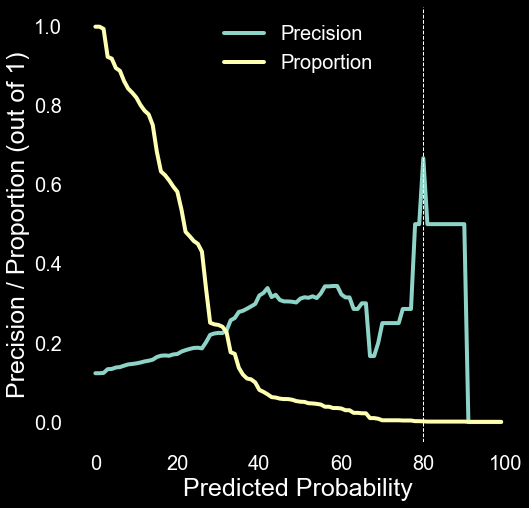

In [153]:
from matplotlib import pyplot

plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode
# retrieve performance metrics
x_axis = no_show_precision['percentile']
# plot log loss
fig, ax = pyplot.subplots(figsize=(8,8))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.plot(x_axis, no_show_precision['precision'], label='Precision', lw=4)
ax.plot(x_axis, no_show_precision['proportion'], label='Proportion', lw=4)
ax.legend(prop={'size': 15})
plt.axvline(80, color='white', linestyle='--', lw =1)
pyplot.ylabel('Precision / Proportion (out of 1)', size=25)
#pyplot.title('Tradeoffs for Predicted Probablity Threshold', size=30)
pyplot.xlabel('Predicted Probability', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Hide grid lines
ax.grid(False)

plt.legend(prop={'size': 20})
pyplot.show()
fig.savefig("data/Tradeoffs.png", transparent=True)

In [ ]:
# #storing the pickled model. 
# import pickle
# ##pickle model, code from Lindsay
# ##My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
# ##Don't change anything else unless you really want to.
# with open('insightMVP_model.pkl', 'wb') as fid:
#     pickle.dump(model_xgb_PT, fid,2)  


In [1069]:
import pickle
##pickle model, code from Lindsay
##My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
##Don't change anything else unless you really want to.

#with 1 max depth
#with open('insightMVP_model_simple.pkl', 'wb') as fid:
    
with open('insightMVP_model_2depth.pkl', 'wb') as fid:
    pickle.dump(model_xgb_PT, fid,2)  

In [ ]:

# Load the model from disk
loaded_model = pickle.load(open('insightMVP_model.pkl', 'rb'))



y_pred_model_xgb = loaded_model.predict_proba(X_test)

print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))

In [1070]:
table

PatientId  noshow  percent_noshow
0          9608       0        0.044785
1          9393       0        0.044785
2          9200       0        0.044785
3          8562       0        0.047990
4          9961       0        0.044785
...         ...     ...             ...
3656       7685       0        0.139150
3657       4515       0        0.139150
3658       6830       0        0.155550
3659       1390       1        0.139150
3660      10284       1        0.139150

[3661 rows x 3 columns]

In [1082]:
def highlight_greaterthan(s,threshold,column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]


style1 = table.style.apply(highlight_greaterthan,threshold=0.15,column=['percent_noshow'], axis=1)
df_html = style1.render()
df_html

'<style  type="text/css" >\n    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row979_col0 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row979_col1 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row979_col2 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row984_col0 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row984_col1 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row984_col2 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row1070_col0 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row1070_col1 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0accb77ea56row1070_col2 {\n            background-color:  red;\n        }    #T_77f48146_e12c_11e9_9e0c_e0

In [1079]:
table.style.apply(highlight_greaterthan,threshold=0.15,column=['percent_noshow'], axis=1)